In [41]:
from classifier import *
from torchmetrics.classification import ROC, AUROC, Accuracy, Recall, F1Score, Precision
from torch import tensor
import pandas as pd


In [2]:

data_dir = '../datasets/training/'
val_dir = '../datasets/evaluation/'
test_dir = '../datasets/test/'

train_df = pd.read_csv(data_dir + 'metadata.csv')
val_df = pd.read_csv(val_dir + 'metadata.csv')
test_df = pd.read_csv(test_dir + 'metadata.csv')

train_df['file_name'] = train_df['file_name'].apply(lambda x: data_dir + x)
val_df['file_name'] = val_df['file_name'].apply(lambda x: val_dir + x)
test_df['file_name'] = test_df['file_name'].apply(lambda x: test_dir + x)

MODEL_NAME = 'Hope'
LABEL_RARITY_THRESHOLD = 50
TEST_SCORE_THRESHOLD = 0.5
EPOCHS = 10


one_hot_labels = train_df.drop('file_name', axis=1).sum()[train_df.drop(
    'file_name', axis=1).sum() > LABEL_RARITY_THRESHOLD].index
label_names = train_df.drop('file_name', axis=1)[
    one_hot_labels].columns.tolist()

train_dataset = MultiLabelDataset(
  train_df, transforms=get_image_variations, label_list=one_hot_labels, normalize=normalize_image, augment=get_augment_image, resize=resize_image)
val_dataset = MultiLabelDataset(
  val_df, transforms=get_image_variations, label_list=one_hot_labels, normalize=normalize_image, resize=resize_image)
test_dataset = MultiLabelDataset(
  test_df, transforms=get_image_variations, label_list=one_hot_labels, normalize=normalize_image, resize=resize_image)


In [42]:
model = MultiLabelImageClassifierModel(num_classes=len(
    one_hot_labels), input_size=IMAGE_SIZE, num_channels=7)
model.load_state_dict(torch.load(f'./{MODEL_NAME}.pth'))

model.eval()


MultiLabelImageClassifierModel(
  (model): Sequential(
    (0): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=Tr

In [44]:
preds = []
targets = []

for i in range(len(test_dataset)):
# for i in range(50):
    image, label = test_dataset[i]
    image = image.unsqueeze(0)
    pred = model(image)
    preds.append(list(pred.detach().numpy()[0]))
    targets.append(list(label))

print(preds)

preds = tensor(preds)
targets = tensor(targets)


[[0.8672678, 0.21879953, 0.113970004, 0.21598561, 0.0971289, 0.13447404, 0.07941754, 0.19666034, 0.19006298, 0.09013663, 0.043245565], [0.77261657, 0.18461716, 0.050540034, 0.08832228, 0.0758049, 0.014744994, 0.03846926, 0.11624264, 0.24186668, 0.031404085, 0.014241979], [0.8510981, 0.02484259, 0.036274944, 0.041099027, 0.015667295, 0.04945177, 0.016278477, 0.09535704, 0.43500614, 0.034635235, 0.12046656], [0.9079825, 0.04321966, 0.088295735, 0.0746651, 0.019078253, 0.13056237, 0.021175671, 0.10546995, 0.31151286, 0.036139835, 0.09791012], [0.7811953, 0.10793691, 0.14335552, 0.19599155, 0.10307685, 0.098606095, 0.061329637, 0.22853626, 0.2944024, 0.05114322, 0.06528575], [0.7480349, 0.040776867, 0.062563114, 0.10179531, 0.040786836, 0.06374727, 0.03336624, 0.12553008, 0.4389418, 0.048222695, 0.14981498], [0.7606863, 0.3689365, 0.042398874, 0.11683369, 0.07712193, 0.008934344, 0.046175025, 0.076198176, 0.15575157, 0.04012669, 0.014142949], [0.60006917, 0.11293346, 0.022394624, 0.0385485

In [45]:
# metric_roc = ROC(task='multilabel', num_labels=len(one_hot_labels), average=None, thresholds=0.8)
metric_accuracy = Accuracy(task='multilabel', num_labels=len(one_hot_labels), average=None, thresholds=0.8)
metric_f1 = F1Score(task='multilabel', num_labels=len(one_hot_labels), average=None, thresholds=0.8)
metric_recall = Recall(task='multilabel', num_labels=len(one_hot_labels), average=None, thresholds=0.8)
metric_auroc = AUROC(task='multilabel', num_labels=len(one_hot_labels), average=None, thresholds=None)
metric_precision = Precision(task='multilabel', num_labels=len(one_hot_labels), average=None, thresholds=0.8)
# fpr, tpr, thresholds = metric_roc(preds, targets)


In [46]:
# roc = metric_roc(preds, targets)
acc = metric_accuracy(preds, targets)
f1 = metric_f1(preds, targets)
recall = metric_recall(preds, targets)
auroc = metric_auroc(preds, targets)
precision = metric_precision(preds, targets)

# print(roc)
print('acc', acc)
print('f1', f1)
print('recall', recall)
print('auroc', auroc)
print('precision', precision)


tensor([0.8031, 0.8031, 0.9516, 0.8406, 0.9281, 0.9500, 0.9641, 0.9172, 0.8578,
        0.9625, 0.9734])
tensor([0.8887, 0.0000, 0.0000, 0.0377, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
tensor([0.9941, 0.0000, 0.0000, 0.0192, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])
tensor([0.8129, 0.7130, 0.6734, 0.8049, 0.5834, 0.8096, 0.5868, 0.6825, 0.5678,
        0.4556, 0.7185])
tensor([0.8035, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])


In [48]:
import random

metrics = []
for i in range(len(label_names)):
    metrics.append({
        'label': label_names[i],
        'accuracy': acc[i].item(),
        'recall': recall[i].item(),
        'f1': f1[i].item(),
        'precision': precision[i].item(),
        'auroc': auroc[i].item()
    })
print(metrics)


[{'label': 'Disease_Risk', 'accuracy': 0.8031250238418579, 'recall': 0.7551485910990344, 'f1': 0.7457128313930463, 'precision': 0.7365099657062347, 'auroc': 0.8128576874732971}, {'label': 'DR', 'accuracy': 0.8031250238418579, 'recall': 0.7429530095716401, 'f1': 0.727997054325126, 'precision': 0.7136313562406694, 'auroc': 0.7129594683647156}, {'label': 'ARMD', 'accuracy': 0.9515625238418579, 'recall': 0.6736619244040228, 'f1': 0.6723877931768186, 'precision': 0.6711184725101723, 'auroc': 0.673393726348877}, {'label': 'MH', 'accuracy': 0.840624988079071, 'recall': 0.7494479789515538, 'f1': 0.7603082502310601, 'precision': 0.7714879026511927, 'auroc': 0.804875910282135}, {'label': 'DN', 'accuracy': 0.9281250238418579, 'recall': 0.6961672959168959, 'f1': 0.6892900977536164, 'precision': 0.6825474454262697, 'auroc': 0.5834431052207947}, {'label': 'MYA', 'accuracy': 0.949999988079071, 'recall': 0.7498865315767937, 'f1': 0.7687732964442909, 'precision': 0.7886360120669187, 'auroc': 0.80957031

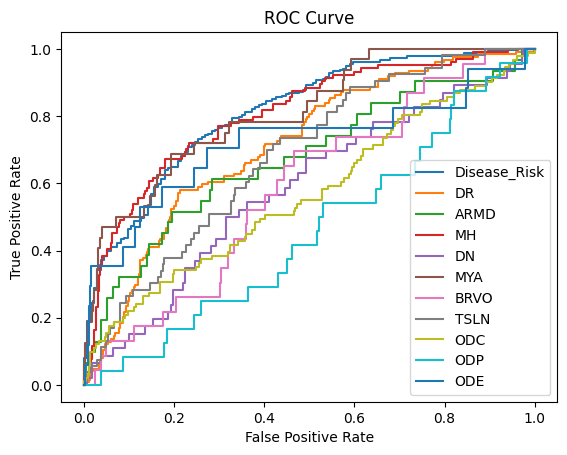

In [6]:
# Plot ROC curve from fpr, tpr, and thresholds obtained from metric
from matplotlib import pyplot as plt

for i in range(len(fpr)):
    plt.plot(fpr[i], tpr[i], label=label_names[i])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
